# Import library

In [769]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.cluster.hierarchy as sch
import random
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator


## Import data

In [770]:
song_data = pd.read_csv('tracks_features.csv',skiprows= (1, 2001), nrows=1000)
# checking for null values
song_data.isnull().sum()

id                  0
name                0
album               0
album_id            0
artists             0
artist_ids          0
track_number        0
disc_number         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
year                0
release_date        0
dtype: int64

## Histogram of the data attributes

array([[<AxesSubplot: title={'center': 'track_number'}>,
        <AxesSubplot: title={'center': 'disc_number'}>,
        <AxesSubplot: title={'center': 'danceability'}>,
        <AxesSubplot: title={'center': 'energy'}>],
       [<AxesSubplot: title={'center': 'key'}>,
        <AxesSubplot: title={'center': 'loudness'}>,
        <AxesSubplot: title={'center': 'mode'}>,
        <AxesSubplot: title={'center': 'speechiness'}>],
       [<AxesSubplot: title={'center': 'acousticness'}>,
        <AxesSubplot: title={'center': 'instrumentalness'}>,
        <AxesSubplot: title={'center': 'liveness'}>,
        <AxesSubplot: title={'center': 'valence'}>],
       [<AxesSubplot: title={'center': 'tempo'}>,
        <AxesSubplot: title={'center': 'duration_ms'}>,
        <AxesSubplot: title={'center': 'time_signature'}>,
        <AxesSubplot: title={'center': 'year'}>]], dtype=object)

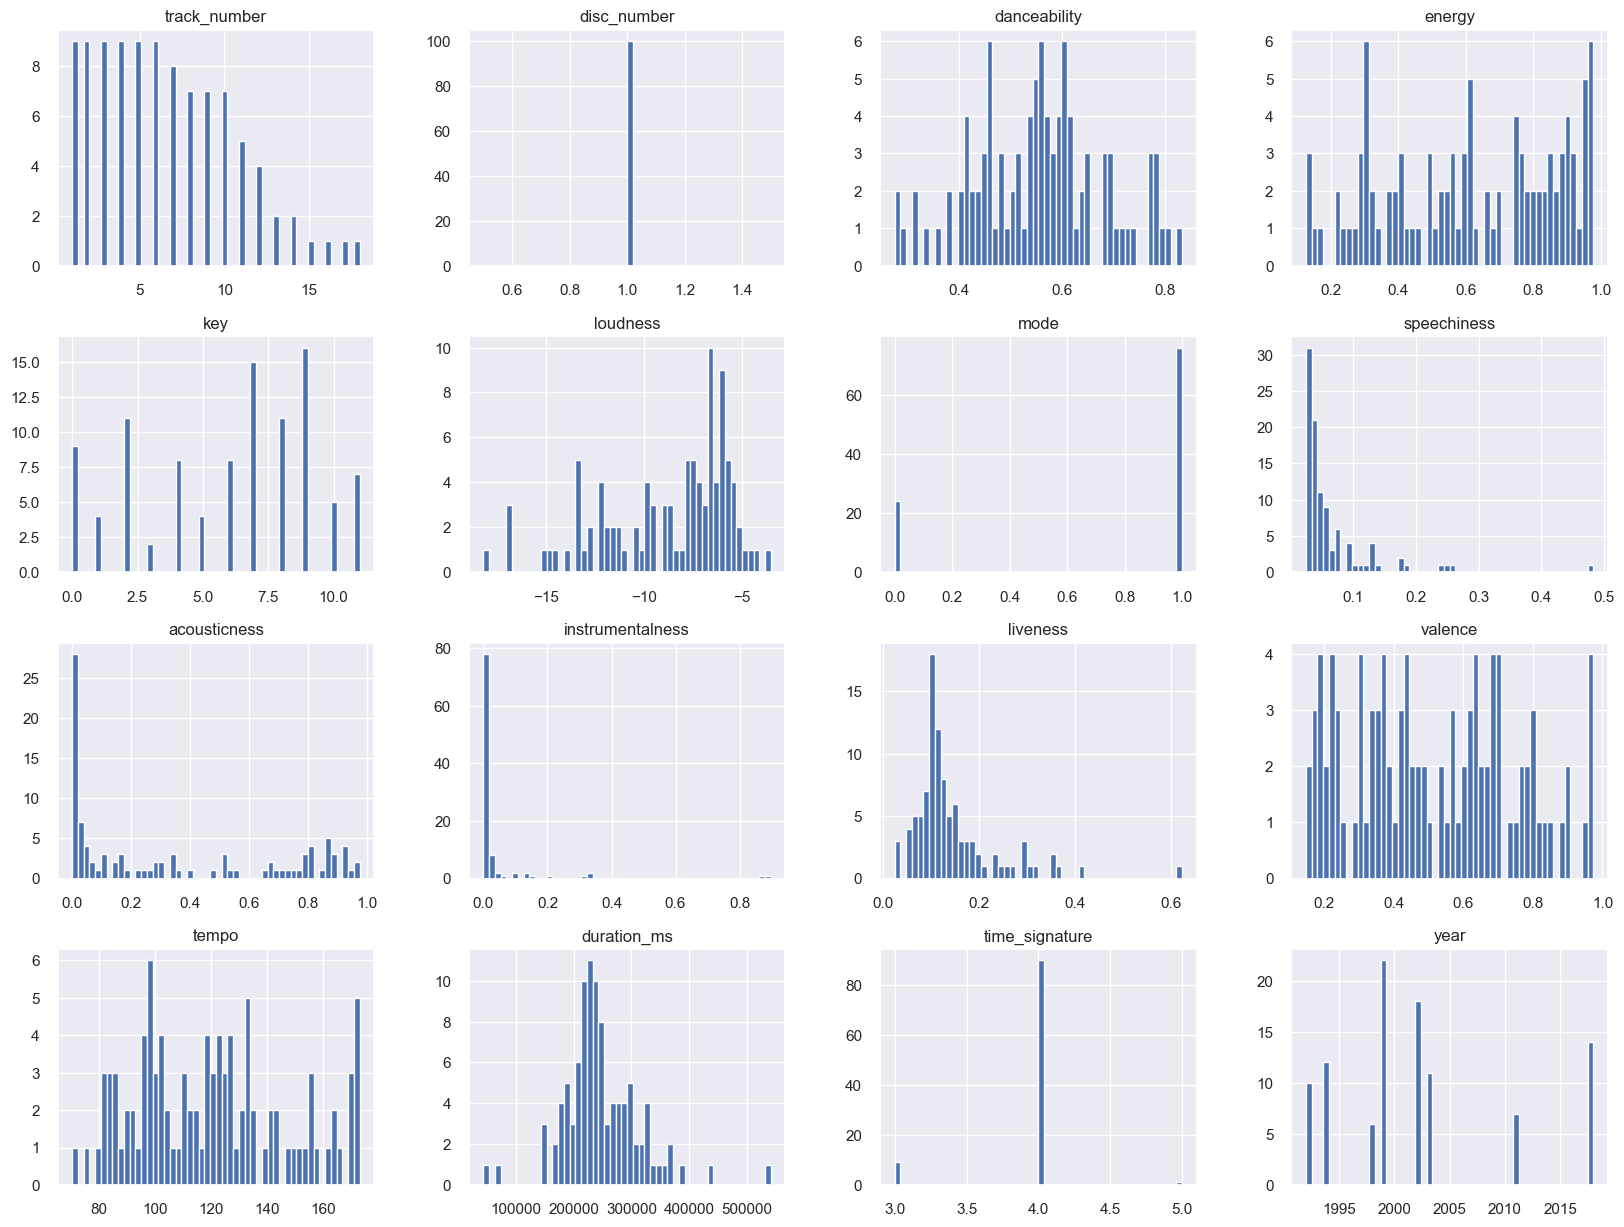

In [771]:
song_data.hist(bins=50, figsize=(20,15))

### Based on the histogram above, we choose "danceability" and "tempo" features because they are normal-distributed

## Normalization

In [772]:
columns_to_scale = ['danceability', 'tempo']
scaler = MinMaxScaler()
scaler.fit(song_data[columns_to_scale])
data_scaled = song_data.copy()
data_scaled[columns_to_scale] = scaler.transform(song_data[columns_to_scale])

X = data_scaled.iloc[:, [9,19]].values


## Remove outliers based on z-scores

In [773]:
# Calculate Z-scores for each attribute
z_scores = np.abs((X - X.mean()) / X.std())

# Define a threshold for outlier detection 
threshold = 3

# Create a mask to identify outliers
outlier_mask = z_scores > threshold

# Remove outliers from the dataset
data_cleaned = X[~outlier_mask.any(axis=1)]

# Print the original and cleaned dataset sizes
print("Original Dataset Size:", X.shape)
print("Cleaned Dataset Size:", data_cleaned.shape)

X = data_cleaned.copy()

Original Dataset Size: (100, 2)
Cleaned Dataset Size: (100, 2)


### X: normalized dataset in danceability and tempo

# I. K-MEANS CLUSTERING

### Apply elbow method to find the optimal number of clusters

In [774]:
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, n_init="auto", init = 'k-means++',random_state=41)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)


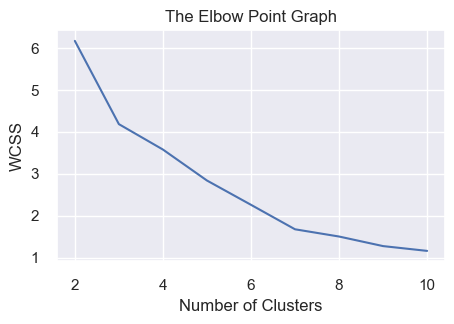

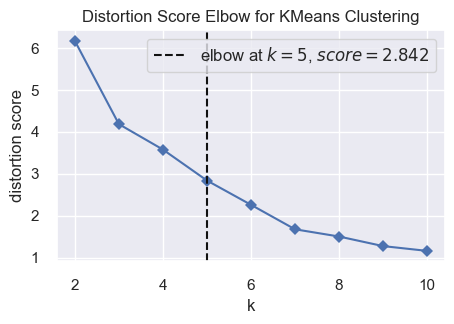

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [775]:
# plot an elbow graph
sns.set()
plt.plot(range(2,11), wcss)
plt.title('The Elbow Point Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# k is range of number of clusters.
visualizer = KElbowVisualizer(kmeans, k=(2,11), timings=False)
# Fit data to visualizer
visualizer.fit(X)
# Finalize and render figure
visualizer.show()

In [776]:
kmeans = KMeans(n_clusters = visualizer.elbow_value_, n_init="auto", init = 'k-means++',random_state=41)

#return a label for each data point based on their cluster
Y = kmeans.fit_predict(X)

print(Y)

[0 2 4 3 0 4 3 4 3 3 0 3 4 3 2 3 4 2 4 4 0 0 1 2 2 2 1 1 2 1 4 1 1 4 1 2 2
 1 2 2 2 1 1 1 2 1 4 4 1 4 1 2 3 2 3 2 0 0 4 2 0 2 0 4 0 0 2 1 2 0 3 0 4 2
 3 0 0 1 1 0 2 2 1 1 2 0 0 0 4 3 4 4 4 3 0 1 0 2 2 2]


### Visualizing all the clusters

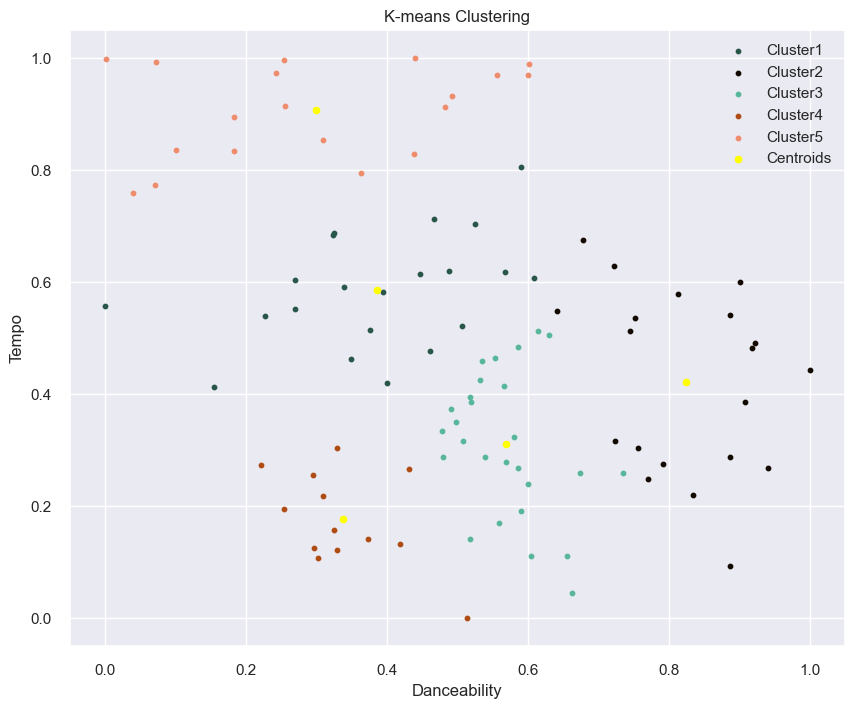

In [777]:
plt.figure(figsize=(10, 8))  

# Generate random colors
colors = ['#' + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in range(visualizer.elbow_value_)]

for cluster_num in range(visualizer.elbow_value_):
    plt.scatter(X[Y == cluster_num, 0], X[Y == cluster_num, 1], s=10, c=colors[cluster_num], label=f'Cluster{cluster_num+1}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 20, c = 'yellow', label = 'Centroids')
plt.title('K-means Clustering')
plt.xlabel('Danceability')
plt.ylabel('Tempo')
plt.legend()
plt.show()

# Davies Bouldin Index

In [778]:
labels = kmeans.labels_
davies_bouldin_score(X, Y)

1.0086306550276485

# Silhouette

In [779]:
silhouette_score(X, Y)

0.3329262998789732

# II. HIERARCHICAL CLUSTERING

Dendrogram to select  the number of clusters

Text(0, 0.5, 'Euclidean distances')

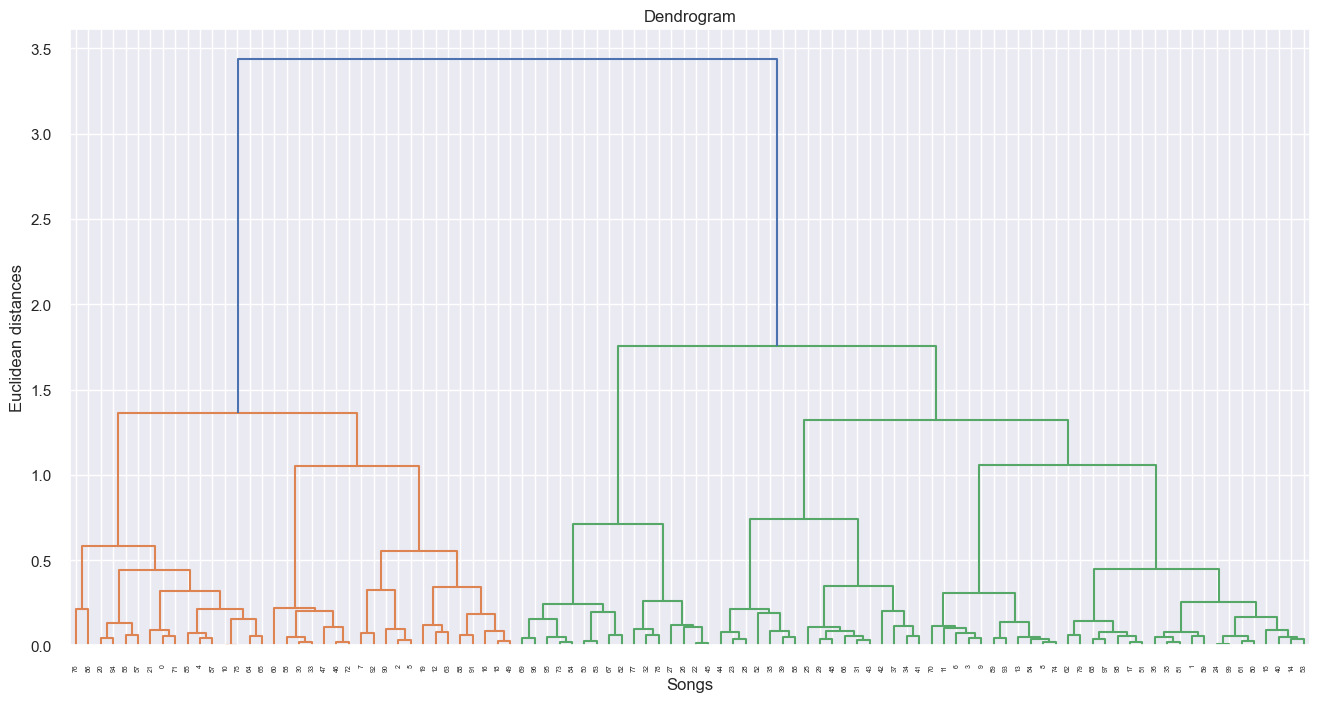

In [780]:
# graph size
plt.figure(1, figsize = (16 ,8))
# creating the dendrogram
dendrogram = sch.dendrogram(sch.linkage(X, method  = "ward"))
# ploting graphabs
plt.title('Dendrogram')
plt.xlabel('Songs')
plt.ylabel('Euclidean distances')

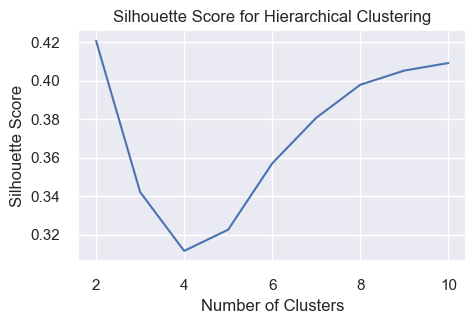

Optimal number of clusters: 2


In [781]:

# Range of cluster numbers to try
min_clusters = 2
max_clusters = 10

# Store silhouette scores
silhouette_scores = []

for n_clusters in range(min_clusters, max_clusters+1):
    # Perform hierarchical clustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    clustering.fit(X)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, clustering.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.plot(range(min_clusters, max_clusters+1), silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Hierarchical Clustering')
plt.show()

# Find the optimal number of clusters
optimal_num_clusters = np.argmax(silhouette_scores) + min_clusters
print("Optimal number of clusters:", optimal_num_clusters)

Apply hierchical clustering

In [782]:
cluster = AgglomerativeClustering(n_clusters = optimal_num_clusters, metric = 'euclidean', linkage = 'ward')
Y_hierchical=cluster.fit_predict(X)

Visualize

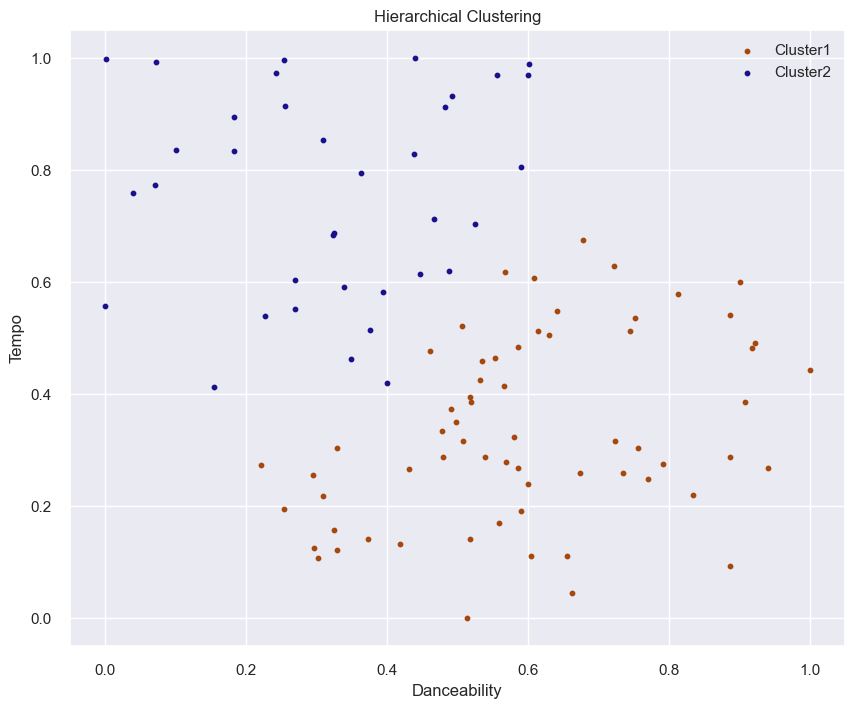

In [783]:
plt.figure(figsize=(10, 8))  

# Generate random colors
colors = ['#' + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in range(optimal_num_clusters)]

for cluster_num in range(optimal_num_clusters):
    plt.scatter(X[Y_hierchical == cluster_num, 0], X[Y_hierchical == cluster_num, 1], s=10, c=colors[cluster_num], label=f'Cluster{cluster_num+1}')
plt.title('Hierarchical Clustering')
plt.xlabel('Danceability')
plt.ylabel('Tempo')
plt.legend()
plt.show()

# Score

In [784]:
davies_bouldin_avg = davies_bouldin_score(X, Y_hierchical)
print("The average DAVIES BOULDIN is :", davies_bouldin_avg)

silhouette_avg = silhouette_score(X, Y_hierchical)
print("The average SILHOUETTE is :", silhouette_avg)

The average DAVIES BOULDIN is : 0.9089993947362343
The average SILHOUETTE is : 0.420681835327102


# III. DENSITY-BASED SCAN CLUSTERING

Calculate the parameters

In [785]:
no_neighbors = 4 # setting the number of neighbors
neighb = NearestNeighbors(n_neighbors=no_neighbors) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(X) # fitting the data to the object
distances,indices=nbrs.kneighbors(X) # finding the nearest neighbours

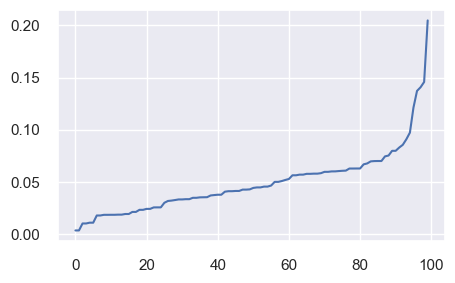

In [786]:
# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

In [787]:
kneedle = KneeLocator(x = range(1, len(distances)+1), y = distances, S = 1.0, 
                      curve = "concave", direction = "increasing", online=True)

# get the estimate of knee point
kneedle.knee_y

0.07998106681460278

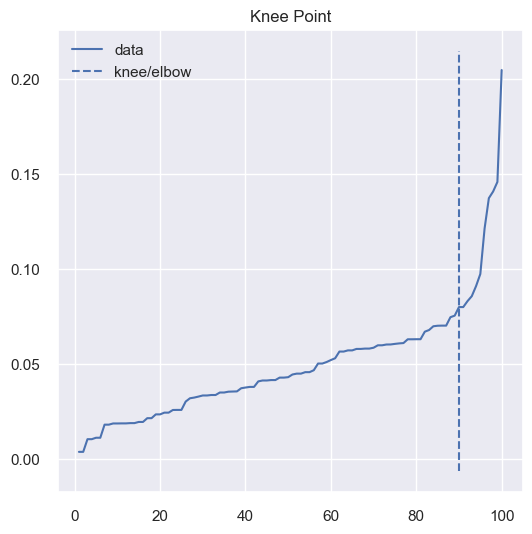

In [788]:
kneedle.plot_knee()
plt.show()

Implementing DBScan

In [796]:
# cluster the data into five clusters
dbscan = DBSCAN(eps = kneedle.knee_y, min_samples = 4).fit(X) # fitting the model
Y_dbscan = dbscan.fit_predict(X) # getting the predicted values
labels = dbscan.labels_ # getting the labels
set(labels) # getting the unique labels


{-1, 0, 1, 2, 3, 4, 5}

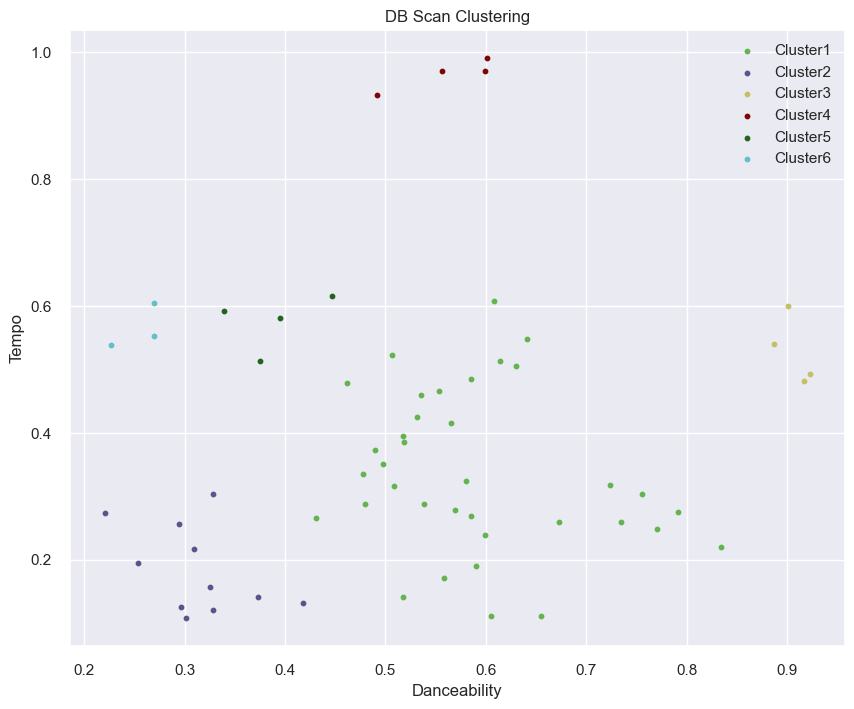

In [797]:
number_of_clusters = len(set(labels)) - 1

plt.figure(figsize=(10, 8))  
# Generate random colors
colors = ['#' + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in range(number_of_clusters)]
for cluster_num in range(number_of_clusters):
    plt.scatter(X[Y_dbscan == cluster_num, 0], X[Y_dbscan == cluster_num, 1], s=10, c=colors[cluster_num], label=f'Cluster{cluster_num+1}')
plt.title('DB Scan Clustering')
plt.xlabel('Danceability')
plt.ylabel('Tempo')
plt.legend()
plt.show()

# Davies Bouldin 

In [791]:
davies_bouldin_score(X, labels)

2.102755430459171

# Silhouette

In [792]:
silhouette_score(X, labels)


0.03629818048583476